In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Задание 1

Рассмотрим применение некоторых классических и хорошо себя показавших алгоритмов-ансамблей. Демонстрировать работу этих алгоритмов будем на данных о потреблении электричества.

## Разведочный анализ данных

Считаем набор данных в датафрейм и изучим его «с высоты птичьего полета».

In [2]:
df = pd.read_csv('/content/electricity_train.csv')
df.describe()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
count,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000
mean,0.498293,4.006566,0.500560,0.057828,0.425939,0.003455,0.423024,0.500243,0.424536
std,0.339907,1.993551,0.294998,0.039052,0.163390,0.010175,0.120600,0.153098,0.494279
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031945,2.000000,0.255319,0.035187,0.309729,0.002283,0.373382,0.414912,0.000000
50%,0.456263,4.000000,0.510638,0.048787,0.444213,0.003467,0.422915,0.414912,0.000000
75%,0.880492,6.000000,0.765957,0.074457,0.536745,0.003467,0.468669,0.605263,1.000000
max,1.000000,7.000000,1.000000,1.000000,0.980809,1.000000,1.000000,0.959211,1.000000


В наборе отсутствуют пропуски. Имеет смысл проверить сбалансированность классов. Выведем долю элементов класса $1$.

In [38]:
df['class'].mean()

0.4245358492648073

Построим матрицу корреляций. Пара наиболее коррелированных признаков - `nswdemand` и `vicdemand`.

<Axes: >

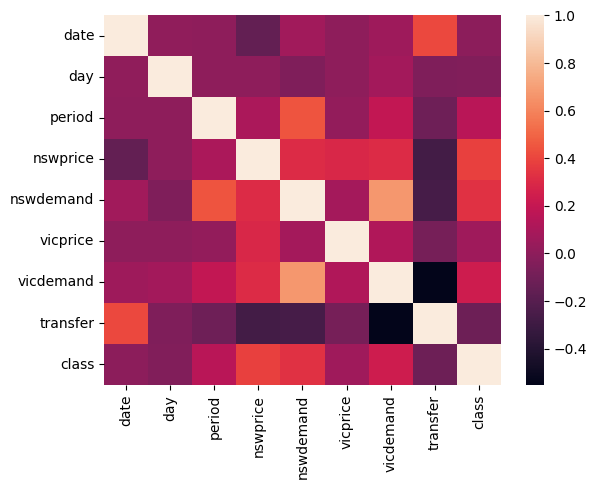

In [4]:
sns.heatmap(df.corr())

Построим гистограммы распределений признаков.

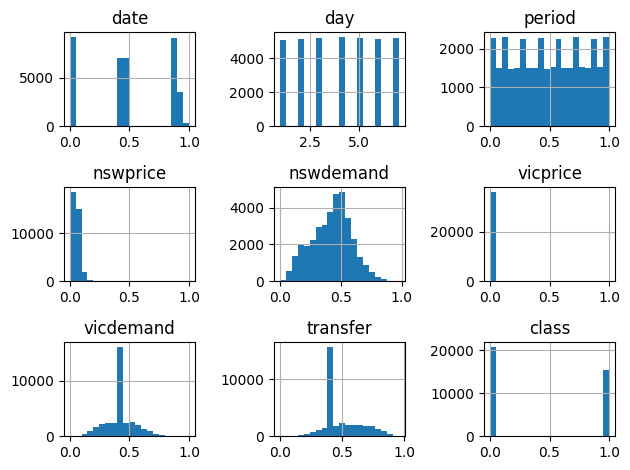

In [5]:
df.hist(bins=20)
plt.tight_layout()
plt.show()

Из полученных иллюстраций видно, что в данных, скорее всего, как и ожидалось, есть некоторая периодичность. Более того, похоже, за нас уже поработали над заполнением пропусков или обработкой выбросов

При помощи `train_test_split` разобьем полученный набор данных на тренеровочную и тестовую выборки.

In [39]:
X = df.drop('class', axis=1)
y = df[['class']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

## Random Forests Classifier

Обучим модель на тренировочных данных.

In [40]:
clf = RandomForestClassifier(random_state=3)
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=3)

Построим `classification_report` полученной модели на тренировочных данных.

In [9]:
y_pred = clf.predict(X_train)
classification_report(y_train, y_pred, output_dict=True)

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16728.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12271.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 28999.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 28999.0}}

Получили переобучение. Что же, еще раз можно ответить, что деревья принятия решений весьма склонны к переобучению.

### Добавление к лесу деревьев GridSearchCV

При помощи `sklearn.model_selection.GridSearchCV` обучим `RandomForestClassifier` на тренировочных данных.


In [41]:
params_grid = {'n_estimators': [100,300,500],
  'max_leaf_nodes': list(range(6,10)),
  'min_samples_leaf': [1,2,3]}
grid = GridSearchCV(RandomForestClassifier(
    bootstrap=False,
    class_weight='balanced',
    n_jobs=-1,
    max_features='sqrt',
    random_state=3),
    params_grid,
    verbose=4,
    cv=3)
grid.fit(X_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.773 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.767 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.777 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.774 total time=   5.7s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.769 total time=   3.8s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.778 total time=   3.8s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.773 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.768 total time=   6.1s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.777 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=2, n_estimators=100;, score=0.773 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=2, n_estimators=100;, score=0.767 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=2, n_estimators=100;, score=0.777 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=2, n_estimators=300;, score=0.774 total time=   3.8s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=2, n_estimators=300;, score=0.769 total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=2, n_estimators=300;, score=0.778 total time=   3.8s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=2, n_estimators=500;, score=0.773 total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=2, n_estimators=500;, score=0.768 total time=   6.7s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=2, n_estimators=500;, score=0.777 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=3, n_estimators=100;, score=0.773 total time=   1.6s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=3, n_estimators=100;, score=0.767 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=3, n_estimators=100;, score=0.777 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=3, n_estimators=300;, score=0.774 total time=   3.8s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=3, n_estimators=300;, score=0.769 total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=3, n_estimators=300;, score=0.778 total time=   4.6s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=3, n_estimators=500;, score=0.773 total time=   6.2s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=3, n_estimators=500;, score=0.768 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=3, n_estimators=500;, score=0.777 total time=   6.3s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=7, min_samples_leaf=1, n_estimators=100;, score=0.778 total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=7, min_samples_leaf=1, n_estimators=100;, score=0.770 total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=7, min_samples_leaf=1, n_estimators=100;, score=0.780 total time=   1.6s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=7, min_samples_leaf=1, n_estimators=300;, score=0.780 total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=7, min_samples_leaf=1, n_estimators=300;, score=0.774 total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=7, min_samples_leaf=1, n_estimators=300;, score=0.783 total time=   5.8s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=7, min_samples_leaf=1, n_estimators=500;, score=0.781 total time=   6.6s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=7, min_samples_leaf=1, n_estimators=500;, score=0.773 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=7, min_samples_leaf=1, n_estimators=500;, score=0.783 total time=   6.5s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=7, min_samples_leaf=2, n_estimators=100;, score=0.778 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=7, min_samples_leaf=2, n_estimators=100;, score=0.770 total time=   1.9s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=7, min_samples_leaf=2, n_estimators=100;, score=0.780 total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=7, min_samples_leaf=2, n_estimators=300;, score=0.780 total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=7, min_samples_leaf=2, n_estimators=300;, score=0.774 total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=7, min_samples_leaf=2, n_estimators=300;, score=0.783 total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=7, min_samples_leaf=2, n_estimators=500;, score=0.781 total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=7, min_samples_leaf=2, n_estimators=500;, score=0.773 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=7, min_samples_leaf=2, n_estimators=500;, score=0.783 total time=   6.5s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=7, min_samples_leaf=3, n_estimators=100;, score=0.778 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=7, min_samples_leaf=3, n_estimators=100;, score=0.770 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=7, min_samples_leaf=3, n_estimators=100;, score=0.780 total time=   1.9s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=7, min_samples_leaf=3, n_estimators=300;, score=0.780 total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=7, min_samples_leaf=3, n_estimators=300;, score=0.774 total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=7, min_samples_leaf=3, n_estimators=300;, score=0.783 total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=7, min_samples_leaf=3, n_estimators=500;, score=0.781 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=7, min_samples_leaf=3, n_estimators=500;, score=0.773 total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=7, min_samples_leaf=3, n_estimators=500;, score=0.783 total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=8, min_samples_leaf=1, n_estimators=100;, score=0.785 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=8, min_samples_leaf=1, n_estimators=100;, score=0.774 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=8, min_samples_leaf=1, n_estimators=100;, score=0.783 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=8, min_samples_leaf=1, n_estimators=300;, score=0.788 total time=   5.9s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=8, min_samples_leaf=1, n_estimators=300;, score=0.780 total time=   4.1s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=8, min_samples_leaf=1, n_estimators=300;, score=0.785 total time=   4.1s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=8, min_samples_leaf=1, n_estimators=500;, score=0.789 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=8, min_samples_leaf=1, n_estimators=500;, score=0.780 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=8, min_samples_leaf=1, n_estimators=500;, score=0.786 total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=8, min_samples_leaf=2, n_estimators=100;, score=0.785 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=8, min_samples_leaf=2, n_estimators=100;, score=0.774 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=8, min_samples_leaf=2, n_estimators=100;, score=0.783 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=8, min_samples_leaf=2, n_estimators=300;, score=0.788 total time=   6.0s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=8, min_samples_leaf=2, n_estimators=300;, score=0.780 total time=   4.1s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=8, min_samples_leaf=2, n_estimators=300;, score=0.785 total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=8, min_samples_leaf=2, n_estimators=500;, score=0.789 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=8, min_samples_leaf=2, n_estimators=500;, score=0.780 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=8, min_samples_leaf=2, n_estimators=500;, score=0.786 total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=8, min_samples_leaf=3, n_estimators=100;, score=0.785 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=8, min_samples_leaf=3, n_estimators=100;, score=0.774 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=8, min_samples_leaf=3, n_estimators=100;, score=0.783 total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=8, min_samples_leaf=3, n_estimators=300;, score=0.788 total time=   5.5s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=8, min_samples_leaf=3, n_estimators=300;, score=0.780 total time=   4.1s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=8, min_samples_leaf=3, n_estimators=300;, score=0.785 total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=8, min_samples_leaf=3, n_estimators=500;, score=0.789 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=8, min_samples_leaf=3, n_estimators=500;, score=0.780 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=8, min_samples_leaf=3, n_estimators=500;, score=0.786 total time=   7.1s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=100;, score=0.789 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=100;, score=0.781 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=100;, score=0.786 total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=300;, score=0.791 total time=   5.8s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=300;, score=0.783 total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=300;, score=0.789 total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=500;, score=0.793 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=500;, score=0.783 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=500;, score=0.790 total time=   7.1s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=9, min_samples_leaf=2, n_estimators=100;, score=0.789 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=9, min_samples_leaf=2, n_estimators=100;, score=0.781 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=9, min_samples_leaf=2, n_estimators=100;, score=0.786 total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=9, min_samples_leaf=2, n_estimators=300;, score=0.791 total time=   5.0s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=9, min_samples_leaf=2, n_estimators=300;, score=0.783 total time=   4.3s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=9, min_samples_leaf=2, n_estimators=300;, score=0.789 total time=   5.8s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=9, min_samples_leaf=2, n_estimators=500;, score=0.793 total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=9, min_samples_leaf=2, n_estimators=500;, score=0.783 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=9, min_samples_leaf=2, n_estimators=500;, score=0.790 total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=9, min_samples_leaf=3, n_estimators=100;, score=0.789 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=9, min_samples_leaf=3, n_estimators=100;, score=0.781 total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=9, min_samples_leaf=3, n_estimators=100;, score=0.786 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=9, min_samples_leaf=3, n_estimators=300;, score=0.791 total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=9, min_samples_leaf=3, n_estimators=300;, score=0.783 total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=9, min_samples_leaf=3, n_estimators=300;, score=0.789 total time=   6.2s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END max_leaf_nodes=9, min_samples_leaf=3, n_estimators=500;, score=0.793 total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END max_leaf_nodes=9, min_samples_leaf=3, n_estimators=500;, score=0.783 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END max_leaf_nodes=9, min_samples_leaf=3, n_estimators=500;, score=0.790 total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              class_weight='balanced',
                                              n_jobs=-1, random_state=3),
             param_grid={'max_leaf_nodes': [6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 300, 500]},
             verbose=4)

Рассмотрим параметры лучшей модели.

In [42]:
grid.best_params_

{'max_leaf_nodes': 9, 'min_samples_leaf': 1, 'n_estimators': 500}

Посмотрим точность полученной модели на тренировочных данных.

In [43]:
y_pred = grid.best_estimator_.predict(X_train)
classification_report(y_train, y_pred, output_dict=True)['accuracy']

0.7911307286458154

Посмотрим точность полученной модели на тестовых данных.

In [44]:
y_pred = grid.best_estimator_.predict(X_test)
classification_report(y_test, y_pred, output_dict=True)['accuracy']

0.795448275862069

От переобучения избавились, но точность кажется низкой.

Один из плюсов случайного леса — можно посмотреть на важность признаков при классификации (обратная задача). Определим название самого важного признака модели.

In [14]:
df.columns[np.argmax(grid.best_estimator_.feature_importances_)]

'nswprice'

Попробуем улучшить результаты, используя другие виды ансамблей.

## Voting Classifier

Обучает все модели, поданные на вход, и предсказывает финальный результат либо по большему числу одинаковых ответов, которые дали модели (hard), либо вычисляет вероятность отнесения объектов к классам по всем моделям и берет argmax.

Используем объект `sklearn.ensemble.VotingClassifier` с параметром `voting='hard'`. В качестве базовых алгоритмов используем классификаторы с соответствующими параметрами: `LogisticRegression(solver='liblinear', random_state=3)`, `SVC(random_state=3)`, `SGDClassifier(random_state=3)`. Обучим модель на тренировочных данных.

In [16]:
clf1 = LogisticRegression(solver='liblinear', random_state=3)
clf2 = SVC(random_state=3)
clf3 = SGDClassifier(random_state=3)

vc = VotingClassifier(estimators=[
        ('lr', clf1), ('svc', clf2), ('sgd', clf3)], voting='hard')
vc.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=3,
                                                 solver='liblinear')),
                             ('svc', SVC(random_state=3)),
                             ('sgd', SGDClassifier(random_state=3))])

Вычислим точность модели на тестовых данных.

In [17]:
y_pred = vc.predict(X_test)
classification_report(y_test, y_pred, output_dict=True)['accuracy']

0.7532413793103448

## Bagging Classifier

Создает несколько объектов одного класса (несколько моделей) и обучает их на непересекающихся подмножествах тренировочных данных, а дальше усредняет ответы.

На основе `sklearn.ensemble.BaggingClassifier`, используя `DecisionTreeClassifier` обучим модель на тренировочных данных.

In [18]:
bg = BaggingClassifier(
      DecisionTreeClassifier(class_weight='balanced'),
      max_samples=0.5,
      max_features=0.5,
      bootstrap=False,
      random_state=3)
bg.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:877: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(bootstrap=False,
                  estimator=DecisionTreeClassifier(class_weight='balanced'),
                  max_features=0.5, max_samples=0.5, random_state=3)

Вычислим точность модели на тестовых данных.

In [19]:
y_pred = bg.predict(X_test)
classification_report(y_test, y_pred, output_dict=True)['accuracy']

0.8321379310344827

# Gradient Boosting Classifier

Градиентный бустинг работает примерно так: создается несколько объектов класса (несколько моделей), они выстраиваются в цепочку так, чтобы каждый следующий пытался исправить ошибки предыдущего. Склонен к переобучению.

Обучим модель на основе `sklearn.ensemble.GradientBoostingClassifier` на тренировочных данных.

In [21]:
gbs = GradientBoostingClassifier(n_estimators=500, learning_rate=0.8, random_state=3, max_depth=2)
gbs.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(learning_rate=0.8, max_depth=2, n_estimators=500,
                           random_state=3)

Вычислим точность модели на тестовых данных.

In [22]:
y_pred = gbs.predict(X_test)
classification_report(y_test, y_pred, output_dict=True)['accuracy']

0.8990344827586206

# AdaBoost Classifier

Работает похожим на градиентный бустинг образом, только последующие модели не пытаются исправить ошибку предыдущих: сначала первый объект обучается на всем датасете, а следующий на основе опыта предыдущего обновляет свои веса так, чтобы исправлять ошибочные предсказания.

На основе `sklearn.ensemble.AdaBoostClassifier`, используя `DecisionTreeClassifier` обучим модель на тренировочных данных.

In [23]:
abc = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=300,
    learning_rate=0.5,
    random_state=3)
abc.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=3),
                   learning_rate=0.5, n_estimators=300, random_state=3)

Вычислим точность модели на тестовых данных.

In [24]:
y_pred = abc.predict(X_test)
classification_report(y_test, y_pred, output_dict=True)['accuracy']

0.8184827586206896

# Stacking Classifier

Обучает несколько объектов класса (несколько моделей) на всем наборе данных, а после — обучает отдельный классификатор на метданных — ответах, полученных обученными ранее моделями.

Используем объект `sklearn.ensemble.StackingClassifier` и обучим модель на тренировочных данных.

In [25]:
estimators = [
    ('rf', RandomForestClassifier(random_state=3)),
    ('svc', SVC(random_state=3))
]
stc = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(random_state=3))
stc.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=3)),
                               ('svc', SVC(random_state=3))],
                   final_estimator=LogisticRegression(random_state=3))

Вычислим точность модели на тестовых данных

In [26]:
y_pred = stc.predict(X_test)
classification_report(y_test, y_pred, output_dict=True)['accuracy']

0.9035862068965517

#Задача 2

Используя весь датасет из предыдущего задания как обучающий, выполним предсказания для зарезервированного набора данных. Для успешного выполнения задания необходимо, чтобы результат превысил пороговое значение, равное 0.925. В качестве метрики используется `accuracy_score()`.

In [45]:
df = pd.read_csv('/content/electricity_train.csv')
X_train = df.drop('class', axis=1)
y_train = df[['class']]
X_test = pd.read_csv('/content/electricity_reserved.csv')

In [46]:
estimators = [
    ('rf', RandomForestClassifier(bootstrap=False,
                                  class_weight='balanced',
                                  n_jobs=-1,
                                  max_features='sqrt',
                                  random_state=3)),
    ('svc', SVC(random_state=3)),
    ('bg', BaggingClassifier(
      DecisionTreeClassifier(class_weight='balanced'),
      max_samples=0.5,
      max_features=0.5,
      bootstrap=False,
      random_state=3)),
    ('abc', AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=300,
    learning_rate=0.5,
    random_state=3)),
    ('gbs', GradientBoostingClassifier(n_estimators=500, learning_rate=0.8, random_state=3, max_depth=2))
]

stc = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(random_state=3))
stc.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       class_weight='balanced',
                                                       n_jobs=-1,
                                                       random_state=3)),
                               ('svc', SVC(random_state=3)),
                               ('bg',
                                BaggingClassifier(bootstrap=False,
                                                  estimator=DecisionTreeClassifier(class_weight='balanced'),
                                                  max_features=0.5,
                                                  max_samples=0.5,
                                                  random_state=3)),
                               ('abc',
                                AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                    max_depth=3),
                                                   learning_rate=0.5,
                                                   n_estimators=300,
                                                   random_state=3)),
                               ('gbs',
                                GradientBoostingClassifier(learning_rate=0.8,
                                                           max_depth=2,
                                                           n_estimators=500,
                                                           random_state=3))],
                   final_estimator=LogisticRegression(random_state=3))

In [ ]:
y_pred = stc.predict(X_test)

In [49]:
with open("output.txt", "w") as f:
  f.write('[')
  for el in y_pred:
    f.write(str(el) + ',')
  f.write(']')

На тестовых данных результат составил 0.927.